In [27]:
!pip install PyQt5 PySide2 opencv-python imageio numpy calib3d --quiet

Traceback (most recent call last):
  File "C:\Users\nilsb\anaconda3\Scripts\pip-script.py", line 6, in <module>
    from pip._internal.cli.main import main
  File "C:\Users\nilsb\anaconda3\lib\site-packages\pip\_internal\cli\main.py", line 8, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "C:\Users\nilsb\anaconda3\lib\site-packages\pip\_internal\cli\autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "C:\Users\nilsb\anaconda3\lib\site-packages\pip\_internal\cli\main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "C:\Users\nilsb\anaconda3\lib\site-packages\pip\_internal\cli\cmdoptions.py", line 22, in <module>
    from pip._internal.cli.progress_bars import BAR_TYPES
  File "C:\Users\nilsb\anaconda3\lib\site-packages\pip\_internal\cli\progress_bars.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "C:\Users\nilsb\ana

In [28]:
import cv2
import imageio
import numpy as np

# TP7 Camera calibration and projective geometry
Camera calibration allows to determine the relation between the camera's pixels (2D coordinates) and points in the real world (3D coordinates). It implies computation using homogenous coordinates. To simplify our implementations, we will use the `calib3d` python library whose code is available at https://github.com/ispgroupucl/calib3d

### Exercice 1
- In `calib3d`'s README, understand the different ways to create and use a `Point3D`.

### Exercice 2
- Given the line defined by the point $C$ and the direction-vector $d$, find the point intersecting the plane defined by the point $P$ and the normal-vector $n$. You can consider the solution exists and is unique.
<img src="images/intersection.png" width="400"/>

**Hints:**
- Don't re-invent the wheel and use internet! You just have to translate formulas to `numpy` operations.

In [29]:
from calib3d import Point3D, Point2D

# Line definition
C = Point3D(1421.258, 3773.159, -1127.69)
d = np.array([[-598.67084591, -3941.06716693, 1602.6136204]]).T

# Plane definition
P = Point3D(10,10,0)
n = np.array([[0,0,-1]]).T

def find_intersection(C, d, P, n):
    """
        Finds the intersection between a line and a plane.
        Arguments:
            C - a Point3D of a point on the line
            d - a non-normalized direction-vector of the line
            P - a Point3D on the plane
            n - the normal vector of the plane
        Returns the Point3D at the intersection between the line and the plane.
    """
    # Write your implementation here
    point3D = np.dot((P - C).T, n) / np.dot(d.T, n)
    point3D = C + d * point3D
    point3D = Point3D(point3D)
    assert isinstance(point3D, Point3D) #and 
    return point3D

point3D = find_intersection(C, d, P, n)
assert isinstance(point3D, Point3D), "You must return a Point3D object"
print(point3D)

[[ 999.99918]
 [1000.00022]
 [   0.     ]]


# Camera calibration

It is based on the pinhole camera model that approximate how lights travels between the scene and the camera sensor. Camera calibration is composed of two sets of parameters:

- The **extrinsic parameters** define the position of the camera center and it's heading relative to the world coordinates.
- The **Intrinsic parameters** define sensor and lens parameters. In the simple projective model, no distortion is taken into account.

They are 3 different coordinates systems:

- The 3D coordinates relative to the origin of the world.
- The 3D coordinates relative to the camera center.
- The 2D pixel positions where 3D positions are being projected.

## Extrinsic parameters
The extrinsic parameters defines the transformations from the 3D coordinates relative the origin of the world $\left[x_O,y_O,z_O\right]^T$ to the 3D coordinates relative to the camera center $\left[x_C,y_C,z_C\right]^T$. The camera 3D coordinates system has the following **conventions**:
- The point (0,0,0) is the center of projection of the camera and is called the _principal point_.
- The $z$ axis of the camera points _towards the scene_, the $x$ axis is along the sensor width pointing towards the right of the image, and the $y$ axis is along the sensor height pointing towards the bottom of the image.

### Example
Take a few seconds to move around in the 3D world and understand where the two 3D coordinates systems are located (Don't spend too much time playing, a lot of fun stuff is comming).

<IPython.core.display.Javascript object>


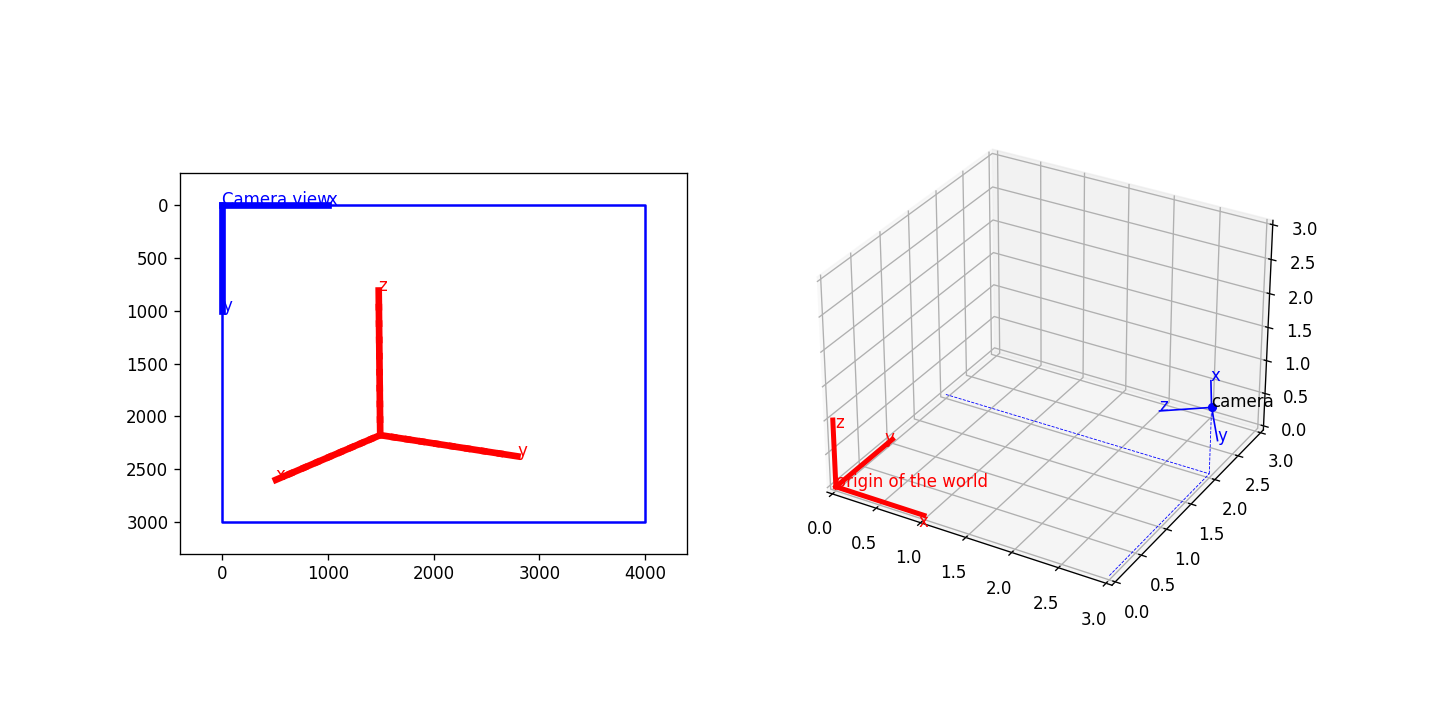

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
from calib3d import Calib
from TP7_utils import create_2D_world, create_3D_world, draw_camera_2D, draw_camera_3D
calib = Calib.load("images/test_calib.pickle")
fig = plt.figure(figsize=(10,5))
ax2D = create_2D_world(fig, subplot=121)
ax3D = create_3D_world(fig, subplot=122, world_limit=3, linewidth=3)
ax3D.text(0,0,0, "origin of the world", color="red")
draw_camera_2D(ax2D, calib)
draw_camera_3D(ax3D, calib, linewidth=1, skip_fov=True)

The _camera_ coordinates system is therefore a transformation of the _world_ coordinates systems with:
- A **rotation** defined by a rotation matrix $R$ using euler angles in a right-hand orthogonal system. The rotation is applied to the world coordinates system to obtain the camera orientation.
- A **translation** defined by a translation vector $T$ representing the position of the center of the world in the camera coordinates system !

Hence,

$$\lambda\left[\begin{matrix}x_C\\y_C\\z_C\\1\end{matrix}\right] = \left[\begin{matrix}
R_{3x3} & T_{3x1}\\{\bf 0}_{1x3}&1
\end{matrix}\right] \left[\begin{matrix}x_O\\y_O\\z_O\\1\end{matrix}\right]$$

**Important notes:**
- The rotation matrix represents a passive (or alias) transformation because it's the coordinates system that rotates and not the objects.
- Euler angles define a 3D rotation starting with a rotation around $x$ followed by a rotation around $y$ followed by a rotation around $z$ (the order matters).
- If $T$ is expressed in the camera coordinate system, the position of the camera expressed in world coordinates system is $C:=-R^{-1}T = -R^{T}T$ (since $R$ is a rotation matrix).

### Exercice 3
- Implement the function `build_R` that creates the rotation matrix associated to the angles `theta` (rotation around $x$), `phi` (rotation around $y$) and `psy` (rotation around $z$).
- Implement the function `build_T` that gets a camera position in the real world coordinates $(x,y,z)$ and returns the position of the origin of the world in the camera basis.

In [5]:
from TP7_utils import build_R2, build_T2

def build_R(theta, phi, psy):
    # Write your implementation here
    RZ = np.array([[np.cos(psy), np.sin(psy), 0],
                   [-np.sin(psy), np.cos(psy), 0],
                   [0, 0, 1]])
    RY = np.array([[np.cos(phi), 0, -np.sin(phi)],
                   [0, 1, 0],
                   [np.sin(phi), 0, np.cos(phi)]])
    RX = np.array([[1, 0, 0],
                   [0, np.cos(theta), np.sin(theta)],
                   [0, -np.sin(theta), np.cos(theta)]])
    R = RZ @ RY @ RX
    
    return R

def build_T(x,y,z, R):
    # Write your implementation here
    # Hint: x,y,z are expressed in the world coordinate system... you must convert them.
    T = -R @ np.array([[x], [y], [z]])
    
    return T

# Checking your implementation
theta, phi, psy = 0.1, 0.2, 0.3
x, y, z = 10, 30, 20

R = build_R(theta, phi, psy)
T = build_T(x,y,z, R)

print("computed R:\n{}\n".format(R))
print("expected R:\n{}\n".format(build_R2(theta, phi, psy)))
print("computed T:\n{}\n".format(T))
print("expected T:\n{}\n".format(build_T2(x,y,z, R)))

computed R:
[[ 0.93629  0.31299 -0.15935]
 [-0.28963  0.9447   0.15379]
 [ 0.19867 -0.09784  0.97517]]

expected R:
[[ 0.93629  0.31299 -0.15935]
 [-0.28963  0.9447   0.15379]
 [ 0.19867 -0.09784  0.97517]]

computed T:
[[-15.56579]
 [-28.52062]
 [-18.5548 ]]

expected T:
[[-15.56579]
 [-28.52062]
 [-18.5548 ]]



## Intrinsic parameters
The intrinsic parameters defines the transformation between the 3D coordinates relative to the camera center $\left[x_C,y_C,z_C\right]^T$ and the 2D coordinates in the camera sensor $\left[i,j\right]^T$. This transformation is called a _projection_ and includes:
- the scale produced by the focal length, with $f$ being the distance between the camera center and the plane on which the image is projected.
- the scale factors $(m_x,m_y)$ relating pixels units to distance units (usually $m_x=m_y$ because pixels are squares).
- the translation from the camera _principal point_ to a top-left origin, with $(u_0,v_0)$ being the position of the _principal point_ expressed in the image coordinates system.
- a skew coefficient $\gamma$ between the $x$ and $y$ axis in the sensor (usually $\gamma=0$ because pixels are squares).

Those transformations can be aggregated in the following matrix called "camera matrix":

$$K := \left[\begin{matrix}f\cdot m_x & \gamma & u_0 \\ 0 & f\cdot m_y & v_0 \\ 0 & 0 & 1\end{matrix}\right]$$

Therefore,
$$\lambda\left[\begin{matrix}i\\j\\1\end{matrix}\right]= \left[\begin{matrix}K_{3x3}&{\bf 0}_{3x1}\end{matrix}\right]\left[\begin{matrix}x_C\\y_C\\z_C\\1\end{matrix}\right]$$

**Notes:**
- The width and height of the image are to be added to those parameters and delimits the sensor width and height in pixels.
- When applying the **direct** projection of a given 3D point, different values of $\lambda$ will always give the **same** 2D point.
- When applying the **inverse** projection on a given 2D point, different values of $\lambda$ will give **different** 3D points.

This is obvious when simplifying the relation between the two points (The column ${\bf 0}_{3x1}$ cancels the homogenous component of the 3D point):

$$\lambda\left[\begin{matrix}i\\j\\1\end{matrix}\right]= \left[\begin{matrix}K_{3x3}\end{matrix}\right]\left[\begin{matrix}x_C\\y_C\\z_C\end{matrix}\right]$$

The 2D vector in homogenous coordinates is not affected by the value of $\lambda$, while the 3D vector is.

### Exercice 4
- What is the point place of all the 3D points that project to a given 2D position in the image space?
-> Des droites font converger la lumière de chaque objet vers un pixel
- Implement the function `build_K` that gets the intrinsic parameters and return the camera matrix. We assue the principal point is centered with the camera sensor and pixels are square.

In [6]:
def build_K(focal, pixel_density, width, height):

    # Pixels are squares
    mx = my = pixel_density # (and not rectangles)
    gamma = 0               # (neither parallelograms)
    
    # Put our principal point in the center of the camera sensor
    u0 = width/2
    v0 = height/2
    
    # TO COMPLETE 
    K = np.array([[focal * mx, 0, u0],
                 [0, focal * my, v0],
                 [0, 0, 1]])
    return K


## Projection model
Therefore, by combining
- the transformation from the world coordinates system to the camera coordinates system (defined by $R$ and $T$)
- with the projection from the camera coordinates system to the image pixels (defined by $K$),

We have a projection model allowing to compute the coordinates of a 2D point in the image $\left(i,j\right)$ from a 3D point in the real world $\left(x,y,z\right)$ described by the matrix $P$:
$$P := \left[\begin{matrix}K_{3x3}&{\bf 0}_{3x1}\end{matrix}\right] \left[\begin{matrix}R_{3x3}&T_{3x1}\\{\bf 0}_{1x3}&1\end{matrix}\right]=K_{3x3}\left[\begin{matrix}R_{3x3}&T_{3x1}\end{matrix}\right]$$

The opposite operation requires to invert $P$ and is done by pseudo-inverse inversion because $P$ is rectangular.

## Projection model implementation

Let's define a Python object to represent a calibration. We call it `Calib` and its constructor receives in arguments the intrinsic and extrinsic parameters:
- image dimensions `width` and `height`,
- the translation vector `T`,
- the rotation matrix `R`,
- the camera matrix `K`.

The method `project_3D_to_2D` allows to compute the position in the image of a 3D point in the world. The opposite operation `project_2D_to_3D` requires an additional parameter `Z` that tells the $z$ coordinate of the 3D point.

### Exercice 5
1. Compute `P`, `Pinv` and `Kinv` in `Calib`'s constructor using `numpy` and store them as attributes of the `Calib` object.
2. Implement the `project_3D_to_2D` method.
3. Implement the `project_2D_to_3D` method that returns the 3D point projected on `point2D` and for which $z$-coordinate is given by agrument `Z`.

**Hint:** You may use `find_intersection` implemented earlier

In [7]:
import pickle

class Calib():
    # The __init__ function is the constructor of Calib.
    # It is called each time we create a 'Calib' object.
    # The '*' in the arguments force to use keywords arguments instead of nameless values
    # The '**_' will be usefull later... it's for additional keywords arguments that are ignored here.
    def __init__(self, *, width, height, T, R, K, **_):
        self.width = width
        self.height = height
        self.T = T
        self.R = R
        self.K = K
        self.P = K @ np.concatenate((R, T), axis=1)  # TODO: compute P
        self.Pinv = np.linalg.pinv(self.P)  # TODO: compute Pinv
        self.Kinv = np.linalg.pinv(self.K)  # TODO: compute Kinv
        self.C = Point3D(-R.T @ T)
        
    def project_3D_to_2D(self, points3D: Point3D):
        """
            Using the calib object, project 3D points in the 2D image space.
            Arguments:
                points3D   - the 3D points to be projected
            Returns:
                The points in the 2D image space on which points3D are projected by calib
        """
        # Write your implementation here
        points = Point2D(self.P @ points3D.H)
        assert isinstance(points, Point2D), "Output of this method should be a Point2D object"
        return points
    
    def project_2D_to_3D(self, points2D: Point2D, Z: float):
        """
            Using the calib object, project 2D points in the 3D image space.
            Arguments:
                point2D    - the 2D points to be projected
                Z          - the Z coordinate of the 3D points (expressed in the world coordinate system)
            Returns:
                The points in the 3D world for which the z=Z and that projects on points2D
        """
        # Write your implementation here
        # Hint: you will have to use the function `find_intersection`
        pointint = Point3D(self.Pinv @ points2D.H)
        d = (pointint - self.C)
        points = find_intersection(self.C, d, Point3D(0, 0, Z), np.array([[0, 0, 1]]).T)
        assert isinstance(points, Point3D), "Output of this method should be a Point3D object"
        return points
        
    @classmethod
    def load(cls, filename):
        """
            Loads a calib object from a file (using the pickle library)
            Argument:
                filename   - the file that stores the calib object
            Returns:
                The calib object      
        """
        with open(filename, "rb") as f:
            return cls(**pickle.load(f))
    
    @property
    def dict(self):
        """
            Gets a dictionnary representing the calib object (allowing easier serialization)
        """
        return {k: getattr(self,k) for k in self.__dict__.keys()}

    def dump(self, filename):
        """
            Saves the current calib object to a file (using the pickle library)
            Argument:
                filename    - the file that will store the calib object
        """
        with open(filename, "wb") as f:
            pickle.dump(self.dict, f)

# Sanity check to make sure your implementation is correct
calib = Calib.load("images/KS-FR-STRASBOURG_bis-0.pickle")
print(calib.project_2D_to_3D(calib.project_3D_to_2D(Point3D(0,0,0)), Z=0))
print(calib.project_3D_to_2D(calib.project_2D_to_3D(Point2D(0,0), Z=0)))

[[-0.]
 [ 0.]
 [ 0.]]
[[ 0.00005]
 [-0.     ]]


Using your functions `build_R`, `build_T` and `build_K`, let's define a function that creates a `Calib` object given all calibration parameters:

In [8]:
def create_calib(position, angles, focal, pixel_density, resolution):
    x, y, z = position
    theta, phi, psy = angles
    width, height = resolution

    K = build_K(focal, pixel_density, width=width, height=height)
    R = build_R(theta, phi, psy)
    T = build_T(x,y,z, R)
    
    # Create the calib object
    return Calib(width=width, height=height, T=T, R=R, K=K)

## Example: Let's create a camera in a virtual 3D world

### Exercice 6
- Let's choose a decent camera: 12Mpx (4000x3000), with a 50mm lens (focal length = 0.05). On our sensor, we put 50 pixels per milimeter (density = 50000).
- Let's put our camera at position (5,4,1) and rotate it towards the origin of the world (angles don't need to be precise. The center of the world just needs to appear in the camera view)

<IPython.core.display.Javascript object>


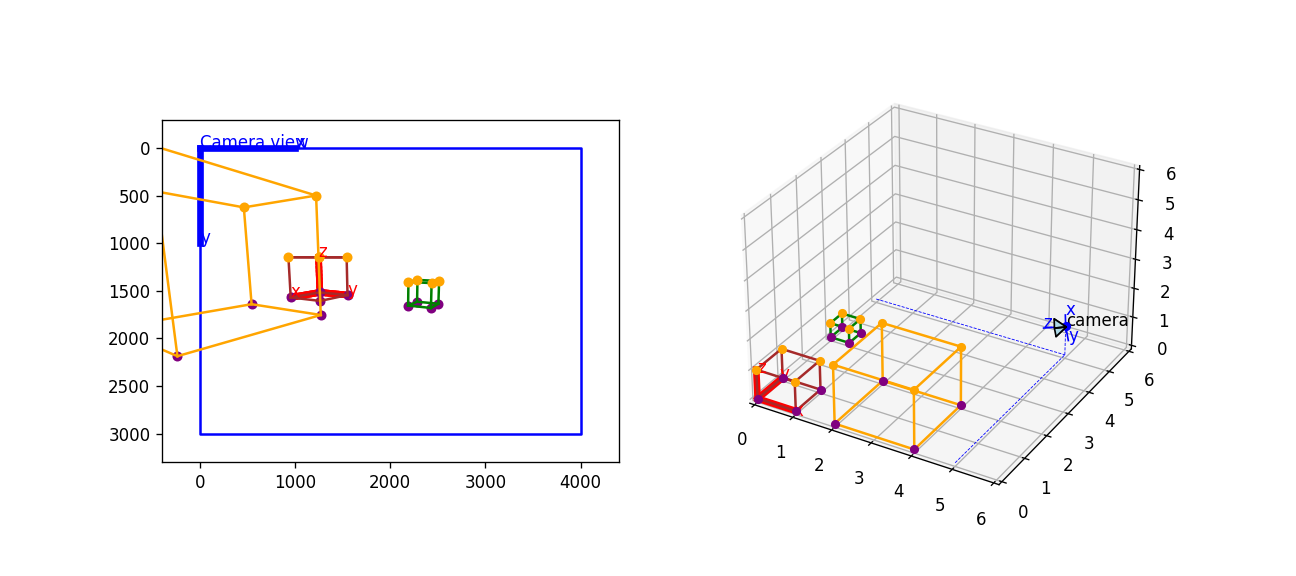

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Intrinsic parameters
width = 4000
height = 3000
focal = 0.05
pixel_density = 50000

# Extrinsic parameters
position = [5, 5, 1]
angles = [5.0, 4.2, 0.25]


camera = create_calib(position, angles, focal, pixel_density, (width, height))

fig = plt.figure(figsize=(9,4))

# The following function creates the 2D world (sensor space) on the left
#  * It inverts y axis: by convention, pixel (0,0) is in top-left corner.
#  * It draws the 2D base (x,y) in blue 
ax2D = create_2D_world(fig, subplot=121)

# The following function creates the 3D world (real space) on the right
#  * It draws the 3D base (x,y,z) in red
ax3D = create_3D_world(fig, subplot=122, world_limit=6)

# The following function draws the camera in the 2D world
#  * It draws a blue rectangle (using calib.width and calib.height)
#  * It draws the origin of the world (using calib.project_3D_to_2D) in red
draw_camera_2D(ax2D, camera)

# The following function draws the camera in the 3D world
#  * It draws a pyramid to represent the camera's angle-of-view
#  * It draws dashed lines to respersent the camera's position
draw_camera_3D(ax3D, camera)


Cool! now, let's add cubes (easy to draw) on our 3D world:

The `Cube` class, implemented in `TP7_utils.py`, allows to create 3D cubes. You don't need to do the implementation but it's really simple :
 - `cube.bottom_base` returns the list of corners (in 3D) on the bottom base of the cube
 - `cube.top_base` returns the list of corners (in 3D) on the top base of the cube
 - `cube.corners` returns the list of all the corners (in 3D) of the cube
 - `cube.edges` returns the list of all edges of the cube (pairs of 2 corners)

In [10]:
from TP7_utils import Cube
cubes = [
    Cube(offset=(0,0,0), size=1, color="brown"),
    Cube(offset=(0,3,0), size=.5, color="green"),
    Cube(offset=(2,0,0), size=2, color="orange")
]

### Exercice 7

The function `draw_cube_3D` gets a `matplotlib.Axes3D` and a `Cube` instances, and draw the edges and the corners in the 3D space. Use the function `project_3D_to_2D` to implement `draw_cube_2D` allowing to draw the cube in the 2D space of the image.

In [11]:
def draw_cube_3D(ax3D, cube):
    # Draw bottom-base corners
    for corner in cube.bottom_base:
        ax3D.scatter(corner.x, corner.y, corner.z, color="purple")

    # Draw edges
    for edge in cube.edges:
        point1, point2 = edge
        ax3D.plot([point1.x, point2.x], [point1.y, point2.y], [point1.z, point2.z], color=cube.color)

    # Draw top-base corners
    for corner in cube.top_base:
        ax3D.scatter(corner.x, corner.y, corner.z, color="orange")

def draw_cube_2D(ax2D, cube, calib):
    """ Given a cube in the 3D world `cube` and a camera defined by `calib`, this function draws
        the cube corners and edges in the camera image defined by `ax2D`.
    """
    # Draw bottom-base corners
    for corner_3D in cube.bottom_base:
        corner_2D = calib.project_3D_to_2D(corner_3D)
        # Fill what misses here
        ax2D.plot(corner_2D.x, corner_2D.y, color="purple", marker=".", markersize=10)
        
    # Draw edges
    for edge in cube.edges:
        point1_3D, point2_3D = edge
        # Fill what misses here
        point1_2D = calib.project_3D_to_2D(point1_3D)
        point2_2D = calib.project_3D_to_2D(point2_3D)
        ax2D.plot([point1_2D.x, point2_2D.x], [point1_2D.y, point2_2D.y], color=cube.color)

        
    # Draw top-base corners
    for corner_3D in cube.top_base:
        # Fill what misses here
        corner_2D = calib.project_3D_to_2D(corner_3D)
        ax2D.plot(corner_2D.x, corner_2D.y, color="orange", marker=".", markersize=10)


And now, using the functions `draw_cube_3D` and `draw_cube_2D`, let's draw the cubes. It's that easy !

<IPython.core.display.Javascript object>


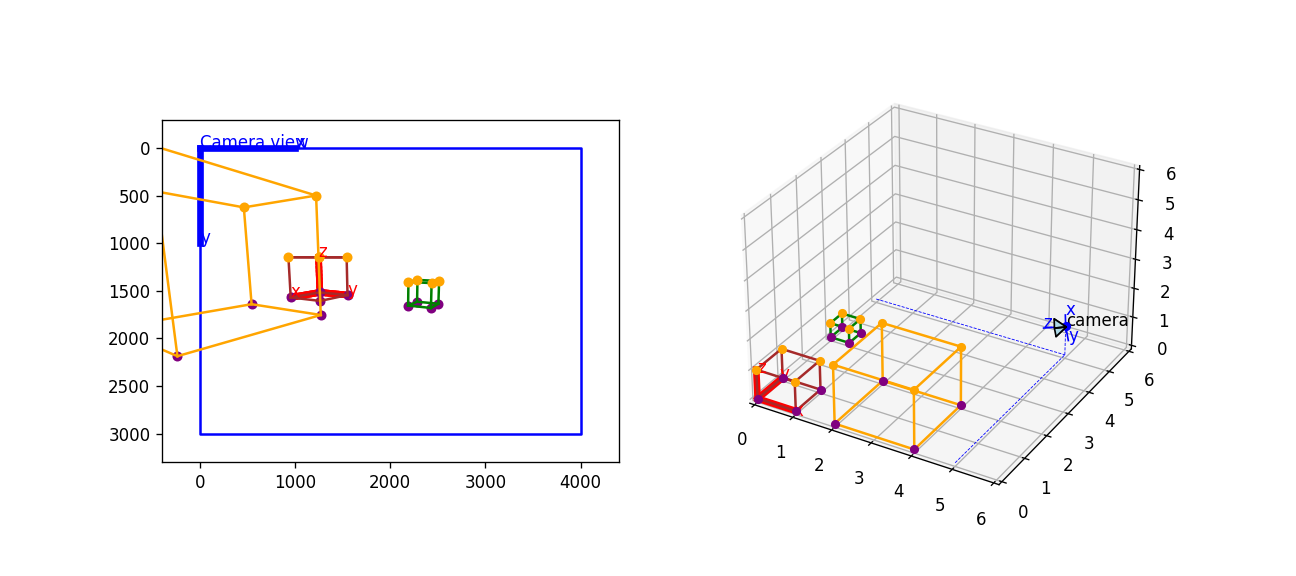

In [23]:
for cube in cubes:
    draw_cube_3D(ax3D, cube)
    draw_cube_2D(ax2D, cube, camera)
display(fig)

### Exercice 8
 - Move the camera *away* by 10 meters in x and 5 meters in y and 2 meters in z and observe the impact on the camera view.
 - Change the focal length by using a 200mm lense and observe the impact on the camera view. => Passant de 0.05 à 0.02, l'angle de vision est plus grand.

## Camera calibration

When you buy a camera, you don't want to measure the intrinsic and extrinsic parameters like $f$, $(u_0,v_0)$ or $(m_x, m_y)$. Actually, with a single image took by the camera, you can retrieve those parameters. It can be done with an optimization algorithm that matches 2D points on the image to 3D points you know. This requires to provide correspondances between 3D points (relative to an origin you choose) and 2D pixel coordinates in the image (relative to the top-left corner of the image).

The library `opencv` comes with an API allowing to calibrate cameras with a simple capture of a chessboard. The 3D world will be defined by the chessboard detected within the image.
1. the function `findChessboardCorners` finds 2D coordinates of a `M`$\times$`N` chessboard in a given image.
2. the function `calibrateCamera` returns all the parameters of the calibrated camera given the 2D - 3D correspondances.

![chessboard photo](images/chessboard.png "A chessboard photo allows to calibrate a camera.")

Here is a function that matches a chessboard image to a grid of 3D points, and uses the 2D - 3D correspondances found to compute the camera calibration in format it to our `Calib` object.

### Exercice 9
Read the code and understand what it does !

In [13]:
import cv2

def find_calib(image, grid_size=(6,7), verbose=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    M, N = grid_size
    # Create an MxN array of 3D points: (0,0,0), (1,0,0), (2,0,0), ...,(M-1,N-1,0)
    # They are all in the plane z=0, but they are 3D points nevertheless
    points3D = np.zeros((M*N,3), np.float32)
    points3D[:,:2] = np.mgrid[:M,:N].T.reshape(-1,2)

    # Find 2D-3D correspondances
    # The function finds a "chessboard" of size MxN in the image
    ret, points2D = cv2.findChessboardCorners(gray, (M, N))
    if not ret:
        raise Exception("Failed to find a chessboard of size {}x{}".format(M,N))
    
    # Refine the 2D coordinates of the MxN points (not mandatory step, but allows better precision)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    points2D = cv2.cornerSubPix(gray, points2D, winSize=(11,11), zeroZone=(-1,-1), criteria=criteria)
    
    # Find calibration parameters using the 3D points and their position in 2D
    # (the rotation matrix must be converted because we don't use the same convention as cv2)
    # kc is not used currently, you'll see later what it does.
    _, K, kc, r, t = cv2.calibrateCamera([points3D], [points2D], (width, height), None, None)
    
    # retrive `T` and `R` that follow our convention using `t` and `r` output by the `cv2` function
    T = t[0]
    R = cv2.Rodrigues(r[0])[0]
    
    if verbose:
        print("kc={}".format(kc))
        print("K={}".format(K))
        print("R={}".format(R))
        print("T={}".format(T))
    
    calib = Calib(width=width, height=height, T=T, R=R, K=K)
    return calib, points2D

## Chessboard example

With the retrieved `calib` we can now augment the image by drawing things relative to the origin located at the chessboard corner.

**Note:** The image provided contains almost no distortions.

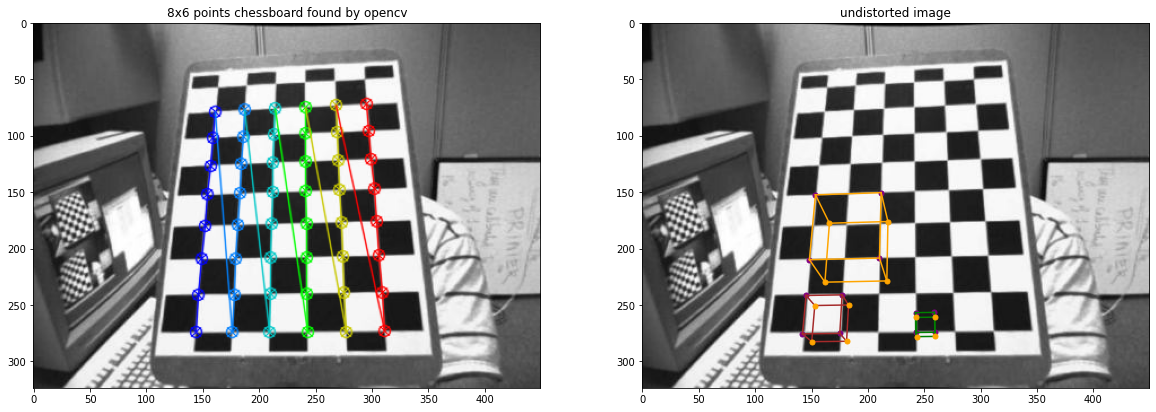

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

image = cv2.imread('images/chessboard.png')

M, N = 8,6
calib, points2D = find_calib(image, (M,N))

# Create figure
_, axes = plt.subplots(1, 2, figsize=(20,20))

# Draw the point found by OpenCV on the image
points_image = cv2.drawChessboardCorners(image.copy(), (M, N), points2D, True)
axes[0].imshow(points_image)
axes[0].set_title("{}x{} points chessboard found by opencv".format(M,N))

# Draw various cubes on the original image
axes[1].imshow(image)
axes[1].set_title("undistorted image")
for cube in cubes:
    draw_cube_2D(axes[1], cube, calib)

### Exercice 10:
- where is the (0,0,0) on the image? => Le point tout en bas à gauche
- where are $x$, $y$ and $z$ pointing? => x,y définissent le plateau et z la haute par rapport au plateau, donc typiquement la hauteur des cubes.

If you are not sure, you should be able to draw them yourself.

**Note:** This simple implementation (drawing with `matplotlib` on 2D or 3D axes) doesn't handle occlusion of objects.

## Limitations of the current projection model

The basic model is not sufficiant to correctly reconstruct the 3D from distorted images. Observe the multiple projection errors caused by the strong distortions in the image below!

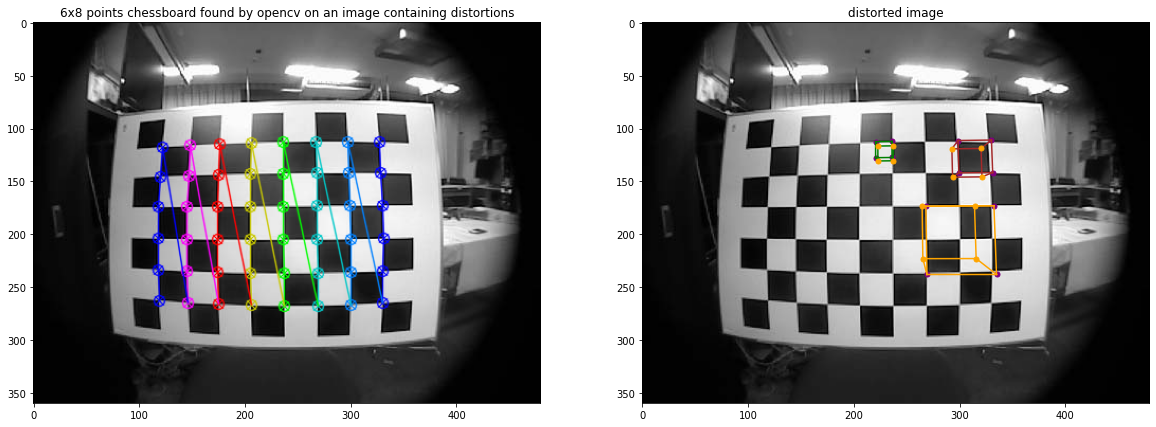

In [15]:
image2 = cv2.imread('images/distorted_chessboard.jpg')

M, N = 6,8
calib, points2D = find_calib(image2, (M,N))

# Create figure
_, axes = plt.subplots(1, 2, figsize=(20,20))

# Draw the point found by OpenCV on the image
points_image2 = cv2.drawChessboardCorners(image2.copy(), (M, N), points2D, True)
axes[0].imshow(points_image2)
axes[0].set_title("{}x{} points chessboard found by opencv on an image containing distortions".format(M,N))

# Draw cubes on the image
axes[1].imshow(image2)
axes[1].set_title("distorted image")
for cube in cubes:
    draw_cube_2D(axes[1], cube, calib)

We need a model of the distortions brought by the lens:

- **radial** distortion cause lines far from principal point to look distorted.
- **tangential** distortion: occur when lens is not prefectly align with the $z$ axis of the camera. 

Many lens distortion models exist. Here, we will use the model used in [opencv](https://docs.opencv.org/3.1.0/d4/d94/tutorial_camera_calibration.html).

## Distortion models

There are actually 2 different models:
- The direct model that applies distortion: find the 2D image (distorted) coordinates of a 3D point given its 2D projected (undistorted) coordinates.
- The inverse model that rectifies distortion: find the 2D (undistorted) coordinate allowing to project a 2D (distorted) image coordinate into 3D.

![](images/distortion_steps.png)

### Direct model: "distort"

The following relationships allows to compute the distorted 2D coordinates $(x_d,y_d)$ on an image from the 2D coordinates provided by the linear projection model $(x_u,y_u)$. Those coordinates are expressed in the camera coordinate system, i.e. they are distances (not pixels) and the point (0,0) is the principal point of the camera.

$$\begin{align}
    x_d &= x_u\overbrace{\left(1 + k_1 {r_u}^2 + k_2 {r_u}^4 + k_3 {r_u}^6+\cdots\right)}^{\text{radial component}} + \overbrace{\left[2p_1 x_uy_u + p_2\left({r_u}^2 + 2{x_u}^2\right)\right]}^{\text{tangeantial component}}\\
    y_d &= y_u\left(1 + k_1 {r_u}^2 + k_2 {r_u}^4 + k_3 {r_u}^6+\cdots\right) + \left[2p_2 x_uy_u + p_1\left({r_u}^2 + 2{y_u}^2\right)\right]
\end{align}$$

Where:
- $k_1, k_2, k_3, \cdots$  are the radial distortion coefficients
- $t_1$, $t_2$ are the tangential distortion coefficients
- ${r_u}^2 := {x_u}^2 + {y_u}^2$

We usually use only 3 radial distortion coefficients, which makes a total of 5 coefficients.  Those coefficients are found by running an optimisation algorithm on a set of 2D point - 3D point relations as we did with `cv2.calibrateCamera`. They are stored in the `kc` vector.

### Inverse model: "rectify"

The distortion operation cannot be inverted analitically using the coefficients $k_1$, $k_2$, $k_3$, $p_1$, $p_2$ (i.e. have $x_u=f_{k_{1,2,3},p_{1,2}}(x_d,y_d)$ and $y_u=f_{k_{1,2,3},p_{1,2}}(x_d,y_d)$). We either need another set of coefficients, or make an approximation.

Here, we will use the following approximation: We will assume that the distortion at point $(x_d,y_d)$ would be the same that distortion at point $(x_u,y_u)$ ! Therefore:

$$\left\{\begin{align}
    2p_1 x_uy_u + p_2\left({r_u}^2 + 2{x_u}^2\right) &\approx 2p_1 x_dy_d + p_2\left({r_d}^2 + 2{x_d}^2\right)\\
    2p_2 x_uy_u + p_1\left({r_u}^2 + 2{y_u}^2\right) &\approx 2p_2 x_dy_d + p_1\left({r_d}^2 + 2{y_d}^2\right) \\
    \left(1 + k_1 {r_u}^2 + k_2 {r_u}^4 + k_3 {r_u}^6+\cdots\right) &\approx \left(1 + k_1 {r_d}^2 + k_2 {r_d}^4 + k_3 {r_d}^6+\cdots\right)
   \end{align}\right.
    $$
    
If this approximation holds, it's much easier to get an analytical expression of $x_u=f_{k_{1,2,3},p_{1,2}}(x_d,y_d)$ and $y_u=f_{k_{1,2,3},p_{1,2}}(x_d,y_d)$.

## Full calibration model implementation
We can now build a calibration model of a camera with distortions:
Let's update our object `Calib` by creating `Calib2` that handles the distortion:
- We provide the distortion coefficients (as a vector `kc`) to the constructor of the object
- We override `project_3D_to_2D` and `project_2D_to_30` by calling respectively `distort` (that applys the distortion after projecting into 2D) and `correct` (that removes the distortions before projecting into 3D).

### Exercice 11
Implement the `rectify` method using our approximation.

In [16]:
class Calib2(Calib):
    def __init__(self, width, height, T, R, K, kc, **_):
        # 'super()' allows to reach a function from 'Calib' (from which 'Calib2' inherits)
        super().__init__(width=width, height=height, T=T, R=R, K=K)
        self.kc = kc

    def project_3D_to_2D(self, point3D, max_iter=20):
        point2D = super().project_3D_to_2D(point3D) # apply 3D to 2D projection
        return self.distort(point2D)                # apply distortion

    def project_2D_to_3D(self, point2D: Point2D, Z: float):
        point2D = self.rectify(point2D)             # rectify distortion
        return super().project_2D_to_3D(point2D, Z) # apply 2D to 3D projection

    def distort(self, point2D):
        if np.any(self.kc):
            rad1, rad2, tan1, tan2, rad3 = self.kc.flatten()
            
            # Convert image coordinates to camera coordinates (with z=1 which is the projection plane)!
            point2D = Point2D(self.Kinv @ point2D.H)
            
            r2 = point2D.x*point2D.x + point2D.y*point2D.y
            delta = 1 + rad1*r2 + rad2*r2*r2 + rad3*r2*r2*r2
        
            dx = np.array([[
                2*tan1*point2D.x*point2D.y + tan2*(r2 + 2*point2D.x*point2D.x),
                2*tan2*point2D.x*point2D.y + tan1*(r2 + 2*point2D.y*point2D.y)
            ]]).T
            point2D = Point2D(point2D*delta + dx)
            
            # Convert camera coordinates to pixel coordinates !
            point2D = Point2D(self.K @ point2D.H)
            
        return point2D

    def rectify(self, point2D):
        if np.any(self.kc):
            rad1, rad2, tan1, tan2, rad3 = self.kc.flatten()
        return point2D
            

We can now correct `find_calib` (let's call it `find_calib2`) to use `Calib2` instead of `Calib`.

In [17]:
import cv2

def find_calib2(image, grid_size=(6,7)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    M, N = grid_size
    # MxN array of 3D points: (0,0,0), (1,0,0), (2,0,0), ...,(M-1,N-1,0)
    points3D = np.zeros((M*N,3), np.float32)
    points3D[:,:2] = np.mgrid[:M,:N].T.reshape(-1,2)

    # Find 2D-3D correspondances
    ret, points2D = cv2.findChessboardCorners(gray, (M, N), None)
    if not ret:
        raise Exception("Failed to find a chessboard of size {}x{}".format(M,N))
    
    # Refine the 2D points (not mandatory step, but allows better precision)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    points2D = cv2.cornerSubPix(gray, points2D, winSize=(11,11), zeroZone=(-1,-1), criteria=criteria)
    
    # Find calibration parameters
    _, K, kc, r, t = cv2.calibrateCamera([points3D], [points2D], (width, height), None, None)
    calib = Calib2(width=width, height=height, T=t[0], R=cv2.Rodrigues(r[0])[0], K=K, kc=kc)
    return calib, points2D

## Exemple
And see the same cubes drawn on the same image with the new calibration model. Note: the lines are still straight lines because we plot segments between two points.

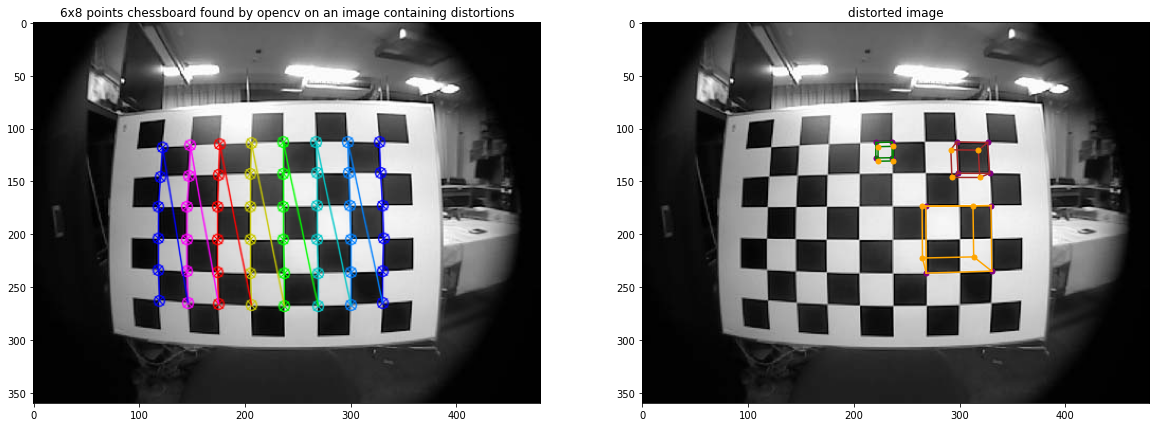

In [18]:
image2 = cv2.imread('images/distorted_chessboard.jpg')

M, N = 6,8
calib, points2D = find_calib2(image2, (M,N))

# Create figure
_, axes = plt.subplots(1, 2, figsize=(20,20))

# Draw the point found by OpenCV on the image
points_image2 = cv2.drawChessboardCorners(image2.copy(), (M, N), points2D, True)
axes[0].imshow(points_image2)
axes[0].set_title("{}x{} points chessboard found by opencv on an image containing distortions".format(M,N))

# Draw cubes on the image
axes[1].imshow(image2)
axes[1].set_title("distorted image")
for cube in cubes:
    draw_cube_2D(axes[1], cube, calib)

## Use case : virtual camera framing the players in a fixed-cameras setup
Keemotion is a spin-off from ELEN department that automates video production of basketball matches. To achieve that, they install multiple fixed cameras to cover the full court. The images are stitched together creating a wide panorama used by an AI algorithm to understand the scene. The algormithm outputs the optimal framing parameters used to re-construct a virtual view framing the action.

left image | right image
- | -
<img src="images/strasbourg0_0.png" width="200"/> | <img src="images/strasbourg0_1.png" width="200"/>


To construct the image provided by the virtual view, the cameras must be calibrated. They use a reference system where the origin of the world is in the court's further-left corner, with $x$ along the length of the court, $y$ along the width, and $z$ towards the earth. The distance unit they use is the $cm$.

<img src="images/convention.png" width="600"/>

They gave us the calibration parameters of the two cameras installed in the arena located in Strasbourg, France.

The court and the two cameras are represented in the following 3D plot (**Note**: there's a bug in the library used: the shapes displayed are sometimes scrambled, specifically on the 2 pyramids representing the two cameras)

[[-2352.94507]
 [  -41.58861]
 [ 3472.46899]]


<IPython.core.display.Javascript object>


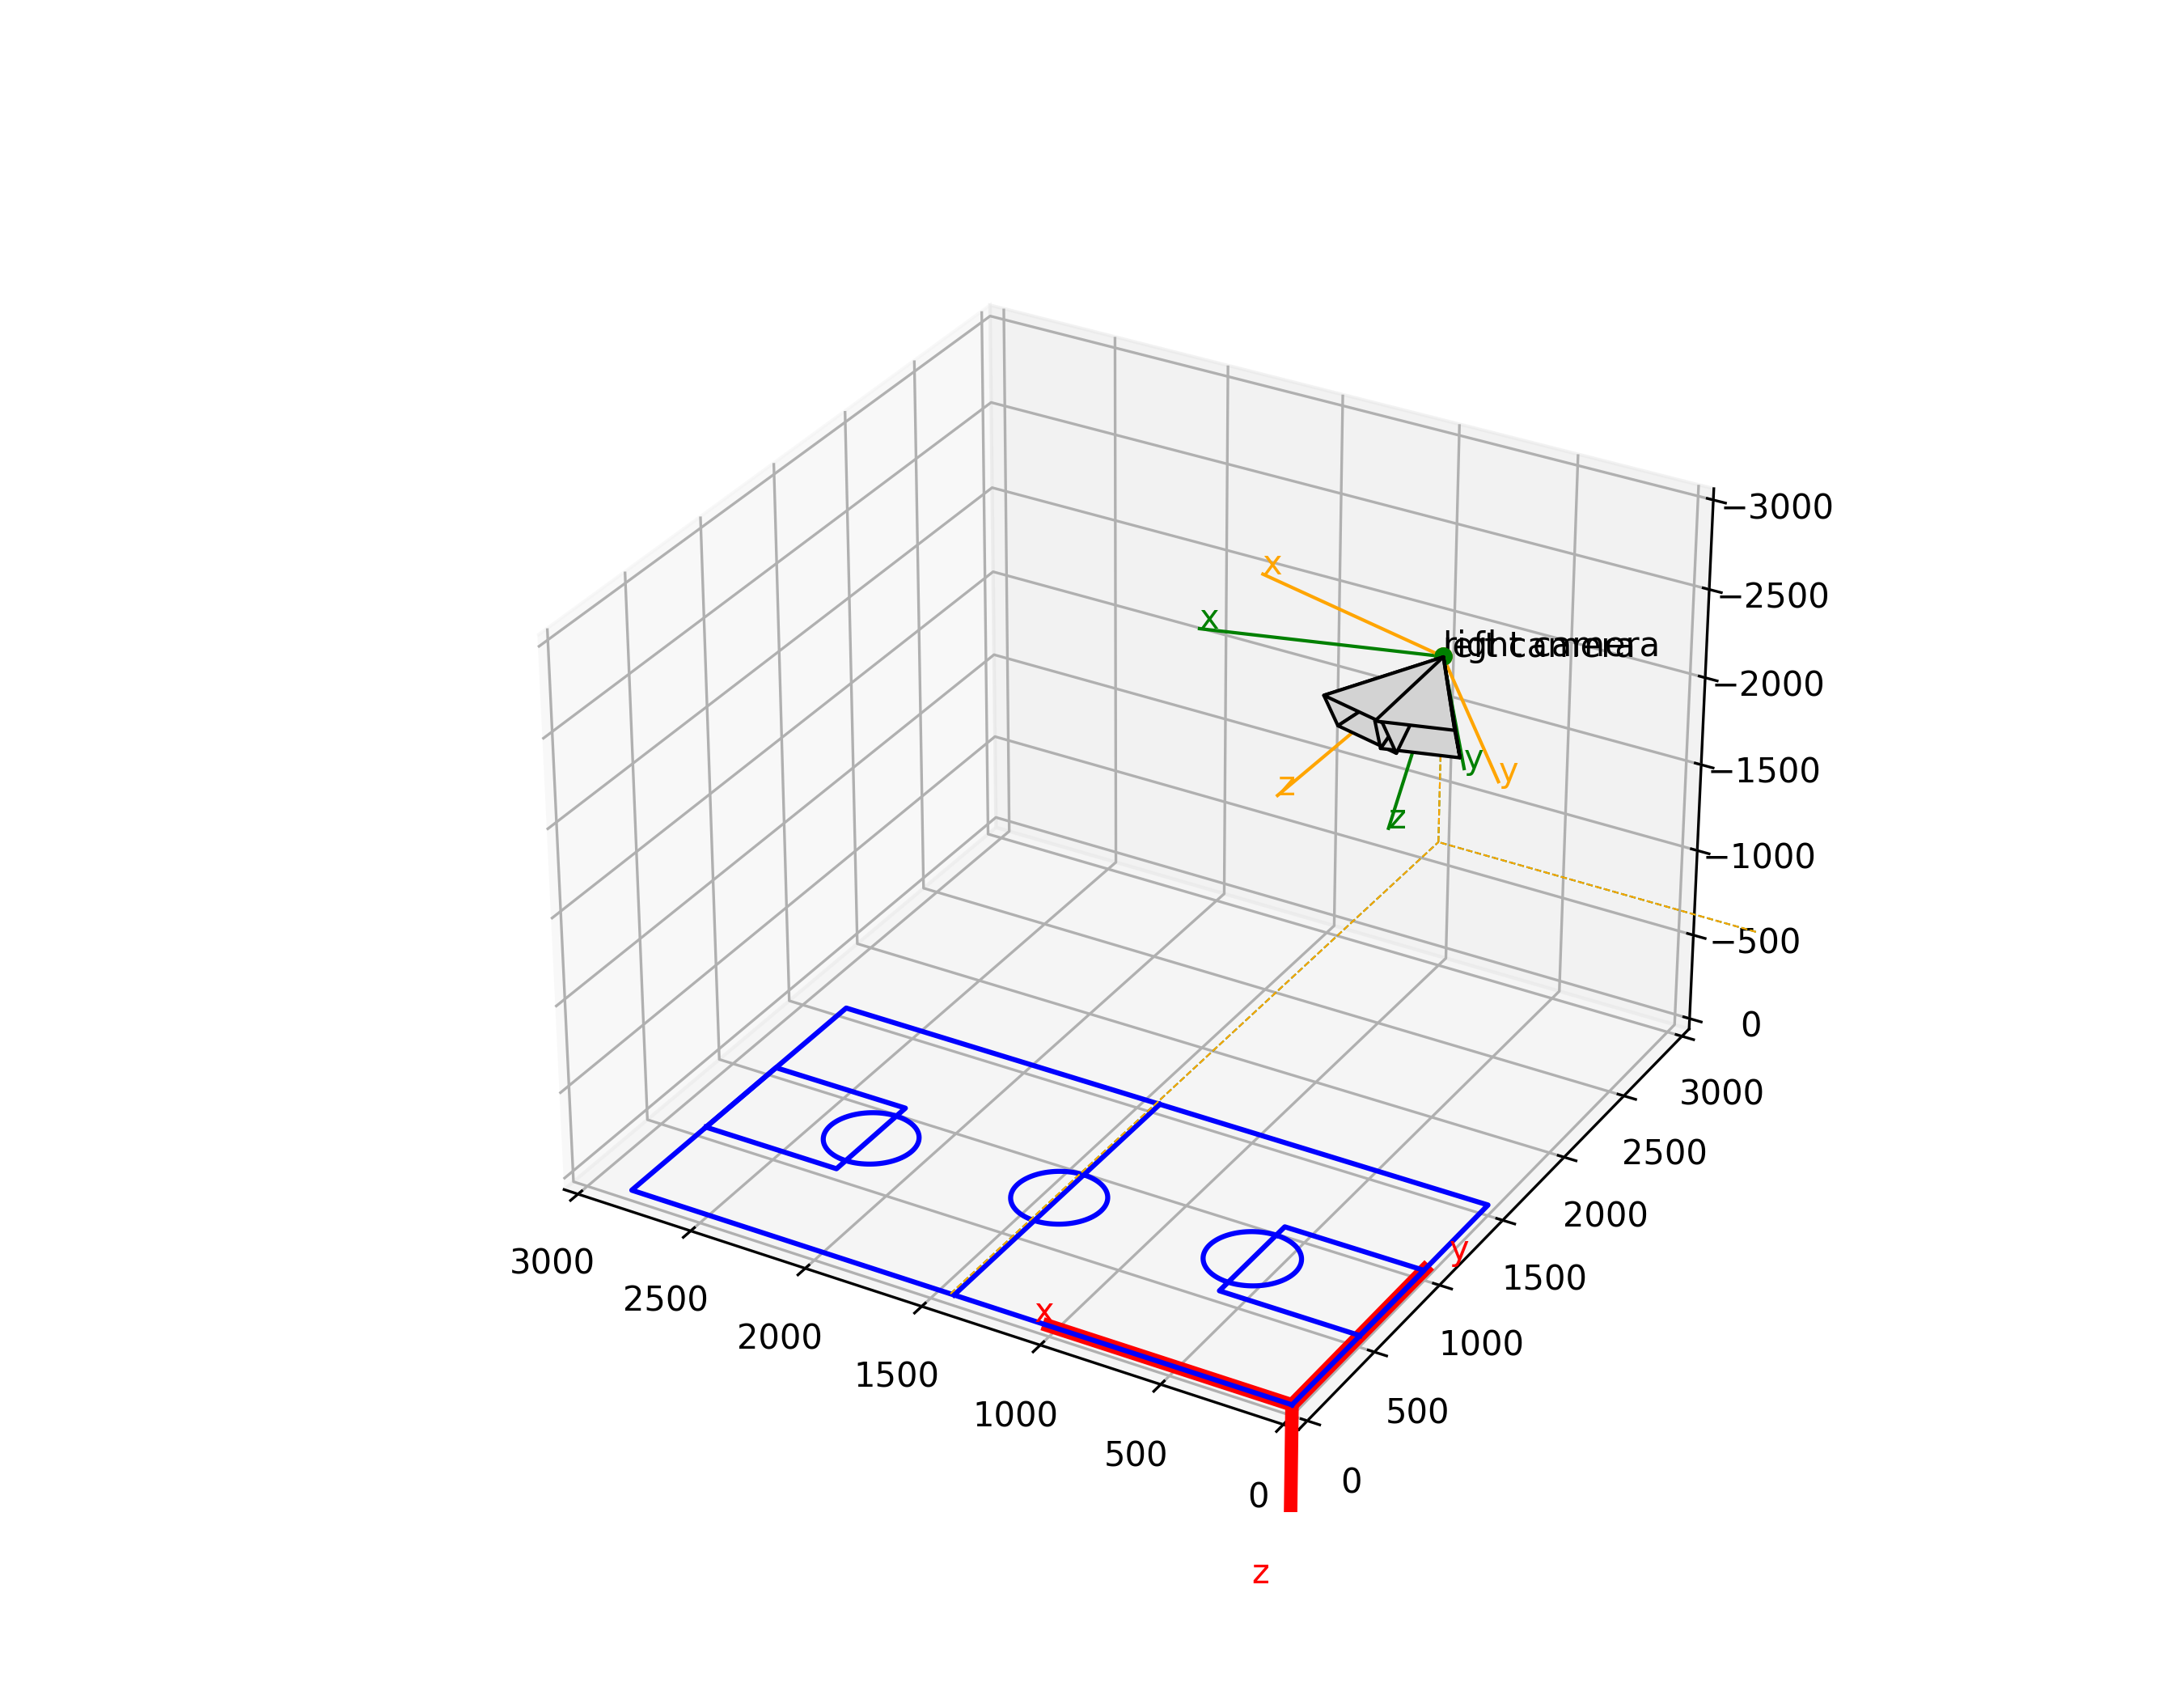

In [32]:
# %matplotlib notebook
%matplotlib notebook
from TP7_utils import draw_court_3D

# We load the calibration with the naive Calib because we don't have mutch distortion in the basket area
left_calib = Calib.load("images/KS-FR-STRASBOURG_bis-0.pickle")
right_calib = Calib.load("images/KS-FR-STRASBOURG_bis-1.pickle")
print(right_calib.T)

fig = plt.figure(figsize=(9,7))
ax3D = create_3D_world(fig, world_limit=3000, z_down=True)
draw_court_3D(ax3D)
draw_camera_3D(ax3D, left_calib, L=1000, color="green", name="left camera")
draw_camera_3D(ax3D, right_calib, L=1000, color="orange", name="right camera")

### Exercice 12
Reconstruct a virtual view framing the action
1. Build a virtual camera (a `Calib` object) that points towards the action, and located at the same position than the left camera.

2. For each pixels of the virtual camera:
    1. Get the 3D point for which $Z=0$ that projects to that pixel of the virtual camera
    2. Get the 2D point of the real camera that projects to the 3D point found above
    3. Use the pixel value of that 2D point for the pixel value of the virtual camera

In [20]:
%matplotlib notebook

## Virtual Camera
position = None # TODO

# I computed the angles for you, but with some trigonometry you can do it yourself
angles = (1.25, 0.32, 0.1) 


# I provide the intrinsic parameters so you don't loose time choosing them.
# I set very small resolution to make the computation faster ! Increase it when your code works ;-)
# I chose a pretty narrow angle-of-view lens
sensor_size = 0.01 # 1 centimeter sensor
width, height = np.array([160, 90]) # 4*[160, 90]
pixel_density = width/sensor_size
focal = 40 # 40 milimeters lens
virtual_camera = create_calib(position, angles, focal=focal/1000, pixel_density=pixel_density, resolution=(width, height))

fig = plt.figure(figsize=(9,7))
ax3D = create_3D_world(fig, world_limit=3000, z_down=True)
draw_court_3D(ax3D)
draw_camera_3D(ax3D, virtual_camera, L=1000, color="red", name="virtual camera")

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
from tqdm import tqdm_notebook # display progress bar
import imageio
%matplotlib inline

right_image = imageio.imread("images/strasbourg0_1.png")
virtual_image = np.zeros((virtual_camera.height, virtual_camera.width, 3), dtype=np.uint8)

for i in tqdm_notebook(range(0,virtual_camera.width)):
    for j in range(0,virtual_camera.height):
        # Write your implementation here
    
plt.figure(figsize=(20,20)).gca().imshow(virtual_image)

### Exercice 13
- Try placing the virtual camera at a different location than the real cameras (and possibly adapt the angles to keep the players in the frame)
- Relative to this new point of view, what is distorted on the image? and what is not? and why?
- What are the benefit of using a virtual camera instead of a simple crop from the original image? (hint: think of what you would get by cropping the camera from exercice 7, especially on the corners or the side of the image)

## Sources:
- https://en.wikipedia.org/wiki/Camera_resectioning
- http://www.dmi.unict.it/~furnari/teaching/CV1617/lab1/
- https://docs.opencv.org/3.4/d4/d94/tutorial_camera_calibration.html